In [1]:
!pip install -U image-classifiers
!pip install -U efficientnet

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     |████████████████████████████████| 50 kB 2.6 MB/s 
Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/


### Mount Drive 
* change working directory

In [2]:
from google.colab import drive
drive.mount('/content/drive')

MessageError: ignored

In [ ]:
cd /content/drive/MyDrive/bdriceleaf/local/

/content/drive/MyDrive/braintumor/local


In [ ]:
ls -la

total 834
-rw------- 1 root root    201 Apr  5 17:30 'config (1).json'
-rw------- 1 root root    363 Apr  5 03:38 'config (2).json'
-rw------- 1 root root    363 Jan 17 06:53 'config (3).json'
-rw------- 1 root root    202 Apr  9 06:21  config.json
-rw------- 1 root root  11392 Apr  6 15:21 'Copy of data (1).ipynb'
-rw------- 1 root root  21320 Apr 15 09:32 'Copy of data.ipynb'
-rw------- 1 root root   2258 Nov  8 15:07 'Copy of main.py'
-rw------- 1 root root  26163 Apr 22 14:54 'Copy of mask-rcnn-using-cats-vs-dogs-dataset.ipynb'
drwx------ 2 root root   4096 Jan 17 06:34  coreLib/
-rw------- 1 root root 138894 Apr  6 14:21  data.ipynb
-rw------- 1 root root  97690 May  2 06:30  main_original.ipynb
-rw------- 1 root root   2258 Apr  9 06:55  main.py
drwx------ 2 root root   4096 Mar  9 18:45  MODEL_DIR/
drwx------ 4 root root   4096 Dec 19 07:38  models/
-rw------- 1 root root   5114 Apr 23 20:07  Normalizedata.ipynb
-rw------- 1 root root   4038 Apr 22 14:51  R-CNN.ipynb
drwx------ 

# PARAMETERS
**BEFORE YOU START**

> Indented block


* **Kaggle dataset GCS path** from kaggle dataset
* **UPLOAD DATA CONFIG**

**SET THE FOLLOWING VARIABLES**
```python
  GCS_PATH    :    The raw path of kaggle gcs 
  EPOCHS      :    number of epochs  
  BUFFER_SIZE :    shuffle size of the buffer    
  MODEL_NAME  :    name of the saved model
  TF_IDEN     :    name of the zipped folder
  DATA_FOLDER :    tfrecords folder
``` 

In [ ]:
import os 
GCS_PATH    =    'gs://kds-6f7dcf3970c50c7f2ec6b403321f579b35ef58a947d8b106eb4cddd0'
MODEL_NAME  =    "densenet121" # @param ["vgg16","vgg19","resnet18","resnet34","resnet50","resnet101","resnet152","resnet50v2","resnet101v2","resnet152v2","resnext50","resnext101","densenet121","densenet169","densenet201","inceptionv3","xception","inceptionresnetv2","seresnet18","seresnet34","seresnet50","seresnet101","seresnet152","seresnext50","seresnext101","senet154","nasnetlarge","nasnetmobile","mobilenet","mobilenetv2"]
DATA_FOLDER =    "content/drive/MyDrive/braintumor/tfrecords"
EPOCHS      =    250   # @param
BUFFER_SIZE =    2048  
MODEL_DIR =    os.path.join(os.getcwd(),"models",f'{MODEL_NAME}') 

if not os.path.exists(MODEL_DIR):
   os.mkdir(MODEL_DIR)

WEIGHT_PATH=os.path.join(MODEL_DIR,f"{MODEL_NAME}.h5")
GCS_PATH    =    f'{GCS_PATH}/{DATA_FOLDER}'
print(GCS_PATH)
print(WEIGHT_PATH)



gs://kds-6f7dcf3970c50c7f2ec6b403321f579b35ef58a947d8b106eb4cddd0/content/drive/MyDrive/braintumor/tfrecords
/content/drive/MyDrive/braintumor/local/models/seresnext101/seresnext101.h5


# Config Reading

In [ ]:
import json

with open('config.json') as f:
  config = json.load(f)

IMAGE_TYPE =  config['image_type']
IMG_DIM    =  config['img_dim']
LABELS     =  config['labels']
NB_CHANNEL =  config['nb_channels']
NB_CLASSES =  config['nb_classes']
NB_TRAIN   =  config['nb_train_data']
NB_EVAL    =  config['nb_eval_data']

config

{'image_type': 'rgb',
 'img_dim': 256,
 'labels': ['Brain', 'No_tumor'],
 'nb_channels': 3,
 'nb_classes': 2,
 'nb_eval_data': 1120,
 'nb_train_data': 5296}

# DEFAULT OPS: TPU TFrecords

## TPU initialize

In [ ]:
import tensorflow as tf 
import os 


print(tf.__version__)
# Detect hardware, return appropriate distribution strategy
try:
    tpu = tf.distribute.cluster_resolver.TPUClusterResolver()  # TPU detection. No parameters necessary if TPU_NAME environment variable is set. On Kaggle this is always the case.
    print('Running on TPU ', tpu.master())
except ValueError:
    tpu = None

if tpu:
    tf.config.experimental_connect_to_cluster(tpu)
    tf.tpu.experimental.initialize_tpu_system(tpu)
    strategy = tf.distribute.experimental.TPUStrategy(tpu)
else:
    strategy = tf.distribute.get_strategy() # default distribution strategy in Tensorflow. Works on CPU and single GPU.

print("REPLICAS: ", strategy.num_replicas_in_sync)

2.8.0
Running on TPU  grpc://10.55.189.2:8470
INFO:tensorflow:Deallocate tpu buffers before initializing tpu system.


INFO:tensorflow:Deallocate tpu buffers before initializing tpu system.


INFO:tensorflow:Initializing the TPU system: grpc://10.55.189.2:8470


INFO:tensorflow:Initializing the TPU system: grpc://10.55.189.2:8470


INFO:tensorflow:Finished initializing TPU system.


INFO:tensorflow:Finished initializing TPU system.


INFO:tensorflow:Found TPU system:


INFO:tensorflow:Found TPU system:


INFO:tensorflow:*** Num TPU Cores: 8


INFO:tensorflow:*** Num TPU Cores: 8


INFO:tensorflow:*** Num TPU Workers: 1


INFO:tensorflow:*** Num TPU Workers: 1


INFO:tensorflow:*** Num TPU Cores Per Worker: 8


INFO:tensorflow:*** Num TPU Cores Per Worker: 8


INFO:tensorflow:*** Available Device: _DeviceAttributes(/job:localhost/replica:0/task:0/device:CPU:0, CPU, 0, 0)


INFO:tensorflow:*** Available Device: _DeviceAttributes(/job:localhost/replica:0/task:0/device:CPU:0, CPU, 0, 0)


INFO:tensorflow:*** Available Device: _DeviceAttributes(/job:worker/replica:0/task:0/device:CPU:0, CPU, 0, 0)


INFO:tensorflow:*** Available Device: _DeviceAttributes(/job:worker/replica:0/task:0/device:CPU:0, CPU, 0, 0)


INFO:tensorflow:*** Available Device: _DeviceAttributes(/job:worker/replica:0/task:0/device:TPU:0, TPU, 0, 0)


INFO:tensorflow:*** Available Device: _DeviceAttributes(/job:worker/replica:0/task:0/device:TPU:0, TPU, 0, 0)


INFO:tensorflow:*** Available Device: _DeviceAttributes(/job:worker/replica:0/task:0/device:TPU:1, TPU, 0, 0)


INFO:tensorflow:*** Available Device: _DeviceAttributes(/job:worker/replica:0/task:0/device:TPU:1, TPU, 0, 0)


INFO:tensorflow:*** Available Device: _DeviceAttributes(/job:worker/replica:0/task:0/device:TPU:2, TPU, 0, 0)


INFO:tensorflow:*** Available Device: _DeviceAttributes(/job:worker/replica:0/task:0/device:TPU:2, TPU, 0, 0)


INFO:tensorflow:*** Available Device: _DeviceAttributes(/job:worker/replica:0/task:0/device:TPU:3, TPU, 0, 0)


INFO:tensorflow:*** Available Device: _DeviceAttributes(/job:worker/replica:0/task:0/device:TPU:3, TPU, 0, 0)


INFO:tensorflow:*** Available Device: _DeviceAttributes(/job:worker/replica:0/task:0/device:TPU:4, TPU, 0, 0)


INFO:tensorflow:*** Available Device: _DeviceAttributes(/job:worker/replica:0/task:0/device:TPU:4, TPU, 0, 0)


INFO:tensorflow:*** Available Device: _DeviceAttributes(/job:worker/replica:0/task:0/device:TPU:5, TPU, 0, 0)


INFO:tensorflow:*** Available Device: _DeviceAttributes(/job:worker/replica:0/task:0/device:TPU:5, TPU, 0, 0)


INFO:tensorflow:*** Available Device: _DeviceAttributes(/job:worker/replica:0/task:0/device:TPU:6, TPU, 0, 0)


INFO:tensorflow:*** Available Device: _DeviceAttributes(/job:worker/replica:0/task:0/device:TPU:6, TPU, 0, 0)


INFO:tensorflow:*** Available Device: _DeviceAttributes(/job:worker/replica:0/task:0/device:TPU:7, TPU, 0, 0)


INFO:tensorflow:*** Available Device: _DeviceAttributes(/job:worker/replica:0/task:0/device:TPU:7, TPU, 0, 0)


INFO:tensorflow:*** Available Device: _DeviceAttributes(/job:worker/replica:0/task:0/device:TPU_SYSTEM:0, TPU_SYSTEM, 0, 0)


INFO:tensorflow:*** Available Device: _DeviceAttributes(/job:worker/replica:0/task:0/device:TPU_SYSTEM:0, TPU_SYSTEM, 0, 0)


INFO:tensorflow:*** Available Device: _DeviceAttributes(/job:worker/replica:0/task:0/device:XLA_CPU:0, XLA_CPU, 0, 0)


INFO:tensorflow:*** Available Device: _DeviceAttributes(/job:worker/replica:0/task:0/device:XLA_CPU:0, XLA_CPU, 0, 0)


REPLICAS:  8


## Training Params

In [ ]:
BATCH_SIZE = 16 * strategy.num_replicas_in_sync
STEPS_PER_EPOCH = NB_TRAIN//BATCH_SIZE
EVAL_STEPS      = NB_EVAL//BATCH_SIZE
print(STEPS_PER_EPOCH,EVAL_STEPS)

41 8


## Data input function

In [ ]:
def data_input_fn(mode): 
    '''
      This Function generates data from gcs
    '''
    
    def _parser(example):
        feature ={  'image'  : tf.io.FixedLenFeature((),tf.string) ,
                    'label'  : tf.io.FixedLenFeature((),tf.int64)
        }    
        parsed_example=tf.io.parse_single_example(example,feature)
        image_raw=parsed_example['image']
        image=tf.image.decode_png(image_raw,channels=NB_CHANNEL)
        image=tf.cast(image,tf.float32)/255.0
        image=tf.reshape(image,(IMG_DIM,IMG_DIM,NB_CHANNEL))
        
        idx = tf.cast(parsed_example['label'], tf.int32)
        label=tf.one_hot(idx,NB_CLASSES,dtype=tf.float32)
        return image,label

    gcs_pattern=os.path.join(GCS_PATH,mode,'*.tfrecord')
    file_paths = tf.io.gfile.glob(gcs_pattern)
    dataset = tf.data.TFRecordDataset(file_paths)
    dataset = dataset.map(_parser)
    dataset = dataset.shuffle(BUFFER_SIZE,reshuffle_each_iteration=True)
    dataset = dataset.repeat()
    dataset = dataset.batch(BATCH_SIZE,drop_remainder=True)
    dataset = dataset.prefetch(tf.data.experimental.AUTOTUNE)
    return dataset


# Data Check

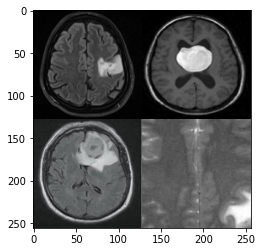

Image Batch Shape: (128, 256, 256, 3)
Target Batch Shape: (128, 2)
tf.Tensor([1. 0.], shape=(2,), dtype=float32)


In [ ]:
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline

train_ds  =   data_input_fn("train")
eval_ds   =   data_input_fn("eval")


for x,y in eval_ds.take(1):
    data=np.squeeze(x[0])
    plt.imshow(data)
    plt.show()
    print('Image Batch Shape:',x.shape)
    print('Target Batch Shape:',y.shape)
    print(y[0])

# MODEL definition
**THIS IS CHANGEABLE**

## Callbacks
**CHANGABLE**

In [ ]:

# reduces learning rate on plateau
lr_reducer = tf.keras.callbacks.ReduceLROnPlateau(factor=0.1,
                                                  cooldown= 10,
                                                  patience=10,
                                                  verbose =1,
                                                  min_lr=0.1e-7)

mode_autosave = tf.keras.callbacks.ModelCheckpoint(WEIGHT_PATH,
                                                  save_best_only=True, 
                                                  verbose=1, 
                                                  period =1)

# stop learining as metric on validatopn stop increasing
early_stopping = tf.keras.callbacks.EarlyStopping(patience=15, 
                                                  verbose=1, 
                                                  mode = 'auto') 

callbacks = [mode_autosave, lr_reducer,early_stopping ]


In [ ]:
from classification_models.tfkeras import Classifiers
with strategy.scope():
    classifier, _ = Classifiers.get(MODEL_NAME)
    net=classifier(input_shape=(IMG_DIM,IMG_DIM,NB_CHANNEL),include_top=False)
    inp=net.input
    x=net.output
    x=tf.keras.layers.GlobalAveragePooling2D()(x)
    x=tf.keras.layers.Dropout(0.1)(x)
    x=tf.keras.layers.Dense(NB_CLASSES,activation="softmax")(x)
    model=tf.keras.Model(inputs=inp,outputs=x)
    model.compile(
        optimizer=tf.keras.optimizers.Adam(learning_rate=1e-4),
        loss = 'categorical_crossentropy',
        metrics=['accuracy']
    )




model.summary()

In [ ]:
history = model.fit(train_ds,
                    steps_per_epoch=STEPS_PER_EPOCH,
                    epochs=EPOCHS,
                    verbose=1, 
                    validation_data=eval_ds,
                    validation_steps=EVAL_STEPS,
                    callbacks=callbacks)

Epoch 1/250
41/41 [==============================] - ETA: 0s - loss: 0.1452 - accuracy: 0.9455
Epoch 1: val_loss improved from inf to 0.58668, saving model to /content/drive/MyDrive/braintumor/local/models/xception/xception.h5
41/41 [==============================] - 67s 525ms/step - loss: 0.1452 - accuracy: 0.9455 - val_loss: 0.5867 - val_accuracy: 0.7793 - lr: 1.0000e-04
Epoch 2/250
41/41 [==============================] - ETA: 0s - loss: 0.0127 - accuracy: 0.9971
Epoch 2: val_loss did not improve from 0.58668
41/41 [==============================] - 7s 165ms/step - loss: 0.0127 - accuracy: 0.9971 - val_loss: 0.6115 - val_accuracy: 0.8027 - lr: 1.0000e-04
Epoch 3/250
41/41 [==============================] - ETA: 0s - loss: 0.0058 - accuracy: 0.9987
Epoch 3: val_loss did not improve from 0.58668
41/41 [==============================] - 6s 156ms/step - loss: 0.0058 - accuracy: 0.9987 - val_loss: 0.6005 - val_accuracy: 0.8213 - lr: 1.0000e-04
Epoch 4/250
41/41 [=========================

## Model history

# Results



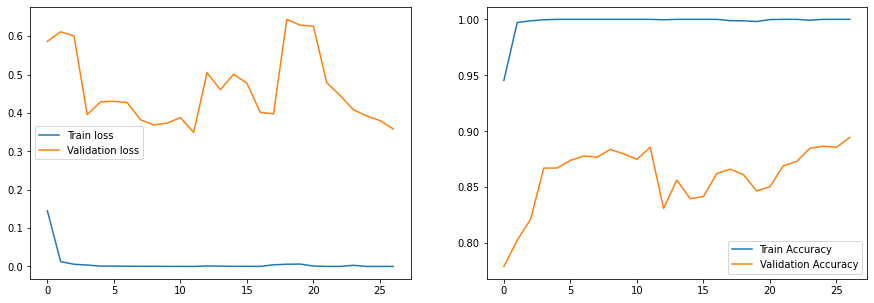

In [ ]:
def plot_history(history,MODEL_DIR,iden):
    """
    Plots model training history 
    """
    fig, (ax_loss, ax_acc) = plt.subplots(1, 2, figsize=(15,5))
    ax_loss.plot(history.epoch, history.history["loss"], label="Train loss")
    ax_loss.plot(history.epoch, history.history["val_loss"], label="Validation loss")
    ax_loss.legend()
    ax_acc.plot(history.epoch, history.history["accuracy"], label="Train Accuracy")
    ax_acc.plot(history.epoch, history.history["val_accuracy"], label="Validation Accuracy")
    ax_acc.legend()
    plt.savefig(os.path.join(MODEL_DIR,f"{iden}.png"))
    plt.show()

# show history
plot_history(history,MODEL_DIR,f"{MODEL_NAME}")

# Model Evaluation on pure testing

In [ ]:
model.load_weights(WEIGHT_PATH)
result = model.evaluate(eval_ds,steps=EVAL_STEPS )
dict(zip(model.metrics_names, result))

8/8 [==============================] - 1s 45ms/step - loss: 0.3545 - accuracy: 0.8828


{'accuracy': 0.8828125, 'loss': 0.35449492931365967}

In [ ]:
from tqdm.auto import tqdm
gts=[]
preds=[]

for x,y in tqdm(eval_ds.take(EVAL_STEPS)):
  y_pred=model.predict(x)
  gt= list(np.argmax(y, axis=1))
  pred=list(np.argmax(y_pred, axis=1))
  gts+=gt
  preds+=pred

gts=np.array(gts)
preds=np.array(preds)

  0%|          | 0/8 [00:00<?, ?it/s]

In [ ]:
from tqdm.auto import tqdm
gts=[]
preds=[]

for x,y in tqdm(eval_ds.take(EVAL_STEPS)):
  y_pred=model.predict(x)
  gt= list(np.argmax(y, axis=1))
  pred=list(np.argmax(y_pred, axis=1))
  gts+=gt
  preds+=pred

gts=np.array(gts)
preds=np.array(preds


    # calculate the fpr and tpr for all thresholds of the classification
    probabilities = model.predict(np.array(gts))
    predictions = probabilities[:, 1]
    fpr, tpr, threshold = metrics.roc_curve(gts, preds)
    roc_auc = metrics.auc(fpr, tpr)
    plt.title('Receiver Operating Characteristic')
    plt.plot(fpr, tpr, 'b', label='AUC = %0.2f' % roc_auc)
    plt.legend(loc='lower right')
    plt.plot([0, 1], [0, 1], 'r--')
    plt.xlim([0, 1])
    plt.ylim([0, 1])
    plt.ylabel('True Positive Rate')
    plt.xlabel('False Positive Rate')
    plt.show()

In [ ]:
import numpy as np
from sklearn import metrics
from sklearn.metrics import roc_curve
y_pred_keras = model.predict(x).ravel()
fpr_keras, tpr_keras, thresholds_keras= roc_curve(gts, preds)

from sklearn.metrics import auc
auc_keras = auc(fpr_keras, tpr_keras)
from tqdm.auto import tqdm
gts=[]
preds=[]

for x,y in tqdm(eval_ds.take(EVAL_STEPS)):
  y_pred=model.predict(x)
  gt= list(np.argmax(y, axis=1))
  pred=list(np.argmax(y_pred, axis=1))
  gts+=gt
  preds+=pred

gts=np.array(gts)
preds=np.array(preds)
y_pred = model.predict(x).ravel()

scores = np.array(preds)
fpr, tpr, thresholds = metrics.roc_curve(gts, preds, pos_label=9)
roc_auc = metrics.auc(fpr, tpr)

from sklearn.metrics import roc_curve

fpr_keras, tpr_keras, thresholds_keras = roc_curve(gts, preds)

from sklearn.metrics import auc
auc_keras = auc(fpr_keras, tpr_keras)

import matplotlib.pyplot as plt
plt.figure(1)
plt.plot([0, 1], [0, 1], 'k--')
plt.plot(fpr_keras, tpr_keras, label='Keras (area = {:.3f})'.format(auc_keras))
plt.plot(fpr_keras, tpr_keras, label='RF (area = {:.3f})'.format(auc_keras))
plt.xlabel('False positive rate')
plt.ylabel('True positive rate')
plt.title('ROC curve')
plt.legend(loc='best')
plt.show()
plt.figure( os.path.join(MODEL_DIR,f"ROC_{MODEL_NAME}.png"))

In [ ]:
from sklearn.metrics import classification_report
print(classification_report(gts, preds, target_names=LABELS))


In [ ]:
from sklearn.metrics import confusion_matrix
import seaborn as sn
import pandas as pd
import matplotlib.pyplot as plt
con_mat=confusion_matrix(preds, gts)
df_cm = pd.DataFrame(con_mat, 
                     index = LABELS,
                     columns = LABELS)
plt.figure(figsize = (10,10))
sn.set(font_scale=1.4)
sn.heatmap(df_cm, annot=True,annot_kws={"size": 16},fmt='g')
plt.savefig( os.path.join(MODEL_DIR,f"confusion_{MODEL_NAME}.png"))
plt.show()



